In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

latent_dim = 128
batch_size = 64

(x_train,_),(x_test,_) = tf.keras.datasets.fashion_mnist.load_data()
all_images = x_train
all_images = all_images.astype("float32") / 255.0
all_images = np.reshape(all_images,(-1,28,28,1))
dataset = tf.data.Dataset.from_tensor_slices(all_images)
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size).prefetch(32)

4422102/4422102 [==============================] - 0s 0us/step


In [3]:

def build_disc():
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Conv2D(32,3,strides=2,padding='same',input_shape=(28,28,1)))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    model.add(tf.keras.layers.Dropout(0.5))

    model.add(tf.keras.layers.Conv2D(64,3,padding='same'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    model.add(tf.keras.layers.Dropout(0.5))

    model.add(tf.keras.layers.Conv2D(128,3,strides=2,padding='same'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    model.add(tf.keras.layers.Dropout(0.5))

    model.add(tf.keras.layers.Conv2D(256,3,padding='same'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    model.add(tf.keras.layers.Dropout(0.5))

    model.add(tf.keras.layers.GlobalMaxPooling2D())
    model.add(tf.keras.layers.Dense(1,activation='sigmoid'))

    return model

discriminator = build_disc()

In [4]:
def build_gen(latent_size):
    model = tf.keras.models.Sequential()

    model.add(tf.keras.layers.Dense(7*7*128,input_dim=latent_size))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    model.add(tf.keras.layers.Reshape((7,7,128)))

    #128 14*14
    model.add(tf.keras.layers.Conv2DTranspose(128,4,strides=2,padding='same',kernel_initializer='glorot_normal'))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    model.add(tf.keras.layers.BatchNormalization())

    #128* 128*28*28
    model.add(tf.keras.layers.Conv2DTranspose(128,4,strides=2,padding='same',kernel_initializer='glorot_normal'))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    model.add(tf.keras.layers.BatchNormalization())

    model.add(tf.keras.layers.Conv2D(1,7,padding='same',activation='tanh',kernel_initializer='glorot_normal'))

    return model

generator = build_gen(latent_dim)

In [5]:
class DCGAN(tf.keras.Model):
    def __init__(self,discriminator,generator,latent_dim):
        super(DCGAN,self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compilem(self,d_optimizer,g_optimizer,loss_fn):
        super(DCGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    def train_step(self, real_images):

        batch_size = tf.shape(real_images)[0]
        random_latent_vects = tf.random.normal(shape=(batch_size,self.latent_dim))

        gen_images = self.generator(random_latent_vects)

        combined_images = tf.concat([gen_images,real_images],axis=0)

        labels = tf.concat([tf.ones((batch_size,1)),tf.zeros((batch_size,1))],axis=0)

        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        #train discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels,predictions)

        grads = tape.gradient(d_loss,self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads,self.discriminator.trainable_weights)
        )

        random_latent_vects = tf.random.normal(shape=(batch_size,self.latent_dim))
        fake_labels = tf.zeros((batch_size, 1))

        #train generator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vects))
            g_loss = self.loss_fn(fake_labels,predictions)

        grads = tape.gradient(g_loss,self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(
            zip(grads,self.generator.trainable_weights)
        )
        return {"d_loss":d_loss,"g_loss":g_loss}


In [6]:
class DCGAN_monitor(tf.keras.callbacks.Callback):
    def __init__(self,latent_dim):
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vects = tf.random.normal(shape=(16, self.latent_dim))
        gen_images = self.model.generator(random_latent_vects)

        plt.close('all')
        fig,axs = plt.subplots(4,4,figsize=(4,4),sharey=True,sharex=True)

        c=0
        for i in range(4):
            for j in range(4):
                axs[i,j].imshow(gen_images[c,:,:,0],cmap='gray')
                axs[i,j].axis('off')
                c+=1

        fig.show()

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5818: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


938/938 [==============================] - 41s 34ms/step - d_loss: 0.4428 - g_loss: 1.3844
Epoch 2/30
938/938 [==============================] - 32s 34ms/step - d_loss: 0.2685 - g_loss: 2.2197
Epoch 3/30
938/938 [==============================] - 33s 35ms/step - d_loss: 0.2574 - g_loss: 2.3897
Epoch 4/30
938/938 [==============================] - 32s 34ms/step - d_loss: 0.2621 - g_loss: 2.3979
Epoch 5/30
938/938 [==============================] - 32s 34ms/step - d_loss: 0.2698 - g_loss: 2.3572
Epoch 6/30
938/938 [==============================] - 32s 34ms/step - d_loss: 0.2783 - g_loss: 2.3493
Epoch 7/30
938/938 [==============================] - 32s 34ms/step - d_loss: 0.2701 - g_loss: 2.3839
Epoch 8/30
938/938 [==============================] - 32s 34ms/step - d_loss: 0.2757 - g_loss: 2.3755
Epoch 9/30
938/938 [==============================] - 32s 34ms/step - d_loss: 0.2634 - g_loss: 2.4724
Epoch 10/30
938/938 [==============================] - 32s 34ms/step - d_loss: 0.2618 - g_los

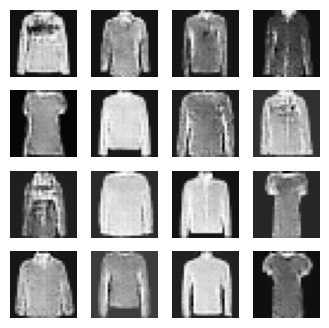

In [7]:
epochs = 30

dcgan = DCGAN(discriminator=discriminator,generator=generator,latent_dim=latent_dim)
dcgan.compilem(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002,beta_1=0.5),
    g_optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002,beta_1=0.5),
    loss_fn=tf.keras.losses.BinaryCrossentropy(from_logits=True)
)

dcgan.fit(dataset,epochs=epochs,callbacks=[DCGAN_monitor(latent_dim=latent_dim)])





